In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
data = pd.read_excel("Churn.xlsx")

In [2]:
label = ["Senior_Citizen","Married","Dependents","Suggest","Phone_Service","Multiple_Lines",
         "Internet_Service","Online_Security","Online_Backup","Device_Protect","Tech_Support",
         "Streaming_TV","Streaming_Movies","Streaming_Music","Unlimited_Data","Paperless_Billing"]
for each in label:
  data[each] = LabelEncoder().fit_transform(data[each])         

In [3]:
internet = pd.get_dummies(data.Internet_Type, prefix="Type")
contract = pd.get_dummies(data.Contract, prefix="Cont")
payment = pd.get_dummies(data.Payment_Method, prefix="Payment")
gender = pd.get_dummies(data.Gender , prefix = "Gender")
data = data.drop(["Gender","Internet_Type","Contract","Payment_Method"],axis=1)

In [4]:
#Concat
newdata = pd.concat([gender,data.iloc[:,:13],internet,data.iloc[:,13:22],contract,payment,data.iloc[:,23:]],axis=1)
newdata.head(5)

,Gender_Female,Gender_Male,Age,Senior_Citizen,Married,Dependents,Number of Dependents,Suggest,Number_of_Suggest,Tenure,...,Cont_Two Year,Payment_Bank Withdrawal,Payment_Credit Card,Payment_Mailed Check,Monthly_Charge,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Satisfaction_Score,Churn
0,0,1,78,1,0,0,0,0,0,1,...,0,1,0,0,39.65,0.00,20,0.00,3,1
1,1,0,74,1,1,1,1,1,1,8,...,0,0,1,0,80.65,0.00,0,390.80,3,1
2,0,1,71,1,0,1,3,0,0,18,...,0,1,0,0,95.45,45.61,0,203.94,2,1
3,1,0,78,1,1,1,1,1,1,25,...,0,1,0,0,98.50,13.43,0,494.00,2,1
4,1,0,80,1,1,1,1,1,1,37,...,0,1,0,0,76.50,0.00,0,234.21,2,1


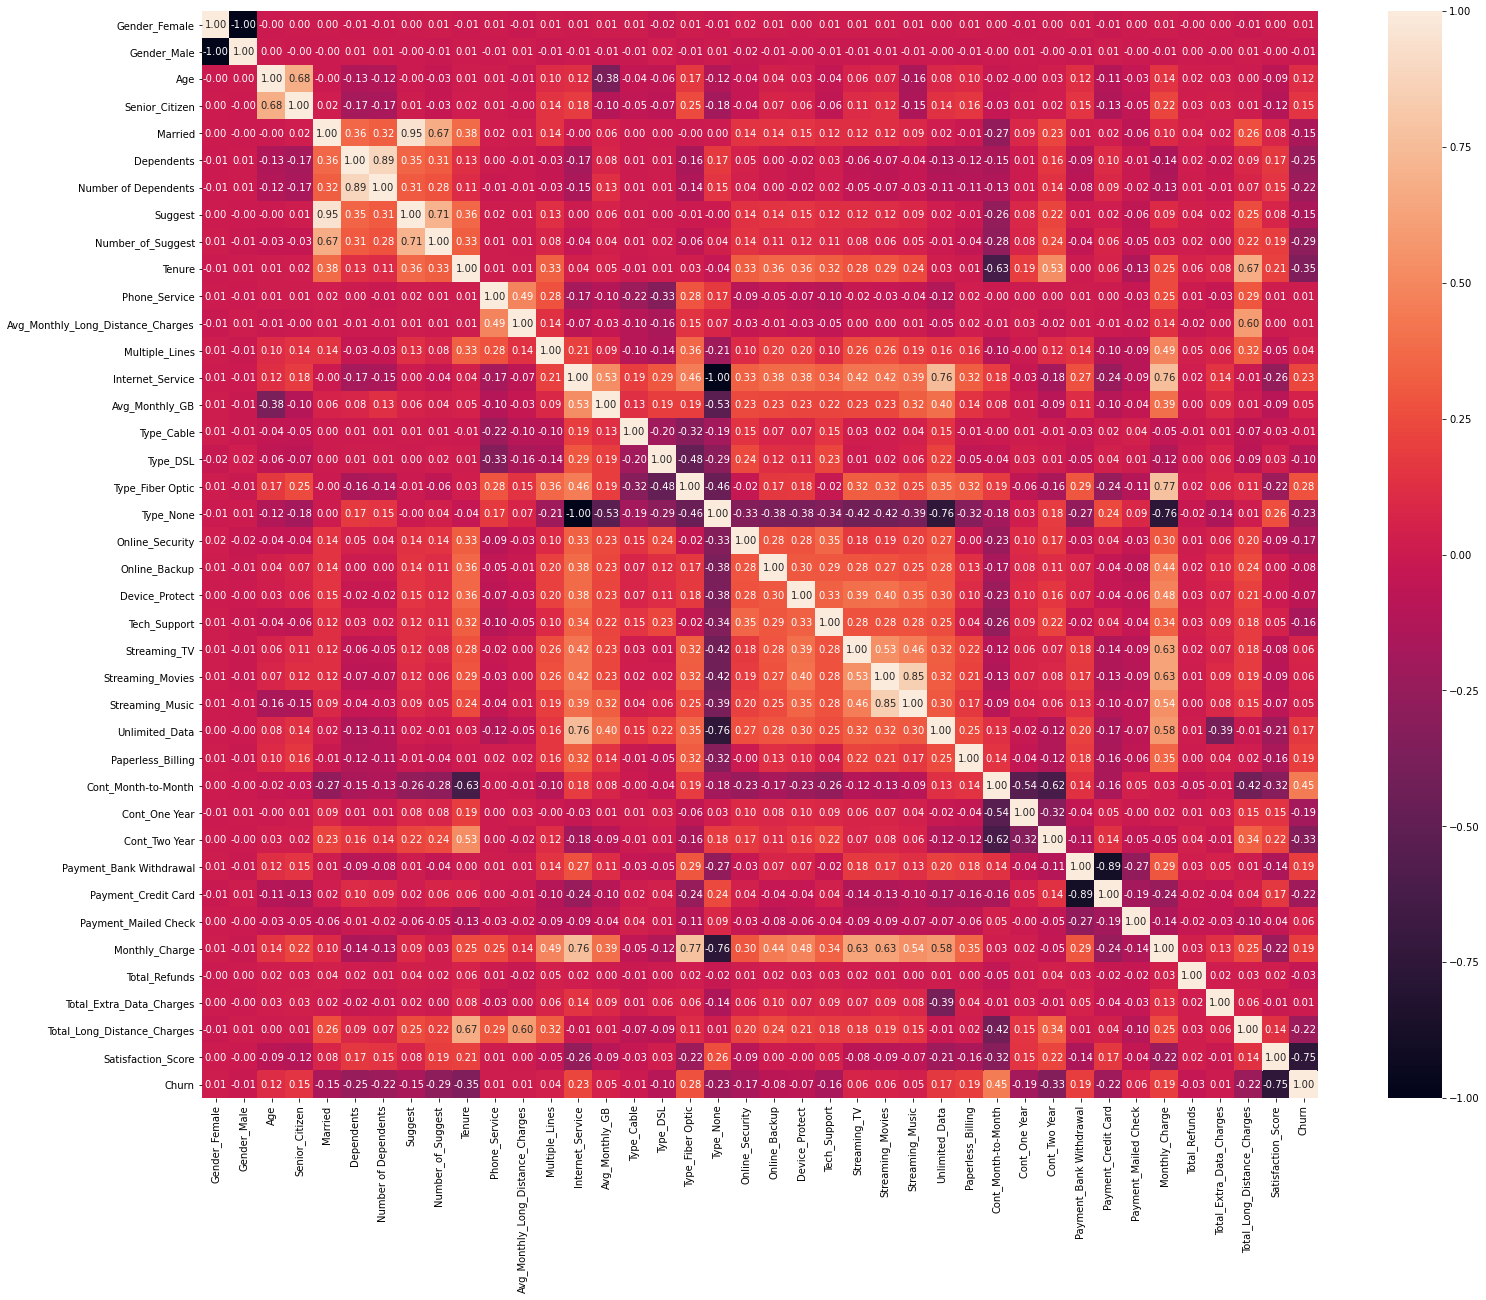

In [5]:
def show_correlations(df, show_chart = True):
    fig = plt.figure(figsize = (25,20))
    corr = df.corr()
    if show_chart == True:
        sns.heatmap(corr, vmin=-1,vmax=1,fmt=".2f",
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr
correlation_df = show_correlations(newdata,show_chart=True)

In [6]:
drop_data = newdata.drop(["Gender_Male","Married","Dependents","Suggest","Type_None","Monthly_Charge","Payment_Credit Card","Senior_Citizen","Cont_Month-to-Month",
                          "Streaming_Music","Unlimited_Data",'Satisfaction_Score'],axis=1)
drop_data.columns

Index(['Gender_Female', 'Age', 'Number of Dependents', 'Number_of_Suggest',
       'Tenure', 'Phone_Service', 'Avg_Monthly_Long_Distance_Charges',
       'Multiple_Lines', 'Internet_Service', 'Avg_Monthly_GB', 'Type_Cable',
       'Type_DSL', 'Type_Fiber Optic', 'Online_Security', 'Online_Backup',
       'Device_Protect', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Paperless_Billing', 'Cont_One Year', 'Cont_Two Year',
       'Payment_Bank Withdrawal', 'Payment_Mailed Check', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Churn'],
      dtype='object')

In [7]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler
y = drop_data["Churn"]
X_sc = StandardScaler().fit_transform(drop_data.drop(["Churn"],axis=1))

In [8]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=21,max_iter=1000)

kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(logr, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(logr, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(logr, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)

kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

logr = logr.fit(X_train,y_train)
logr_pred = logr.predict(X_test)
print(classification_report(y_test,logr_pred))    

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1068
           1       0.65      0.64      0.64       340

    accuracy                           0.83      1408
   macro avg       0.77      0.76      0.76      1408
weighted avg       0.83      0.83      0.83      1408



In [9]:
accuracy_series = pd.Series(data=accuracy_scores)
recall_series = pd.Series(data=recall_scores)
f1_series = pd.Series(data=f1_scores)

Text(0.5, 1.0, 'Lojistik Regresyon')

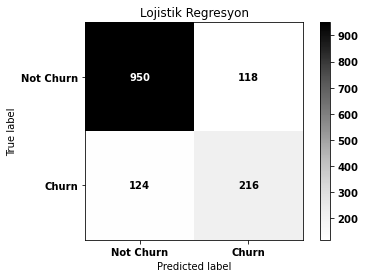

In [10]:
conf_matrix = confusion_matrix(y_test, logr_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("Lojistik Regresyon")

In [11]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21,weights="distance",metric="manhattan")

kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(knn, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(knn, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(knn, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)

kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

knn = knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1068
           1       0.59      0.63      0.61       340

    accuracy                           0.80      1408
   macro avg       0.73      0.75      0.74      1408
weighted avg       0.81      0.80      0.81      1408



In [12]:
accuracy_series = accuracy_series.append(pd.Series(data=accuracy_scores),ignore_index=True)
recall_series = recall_series.append(pd.Series(data=recall_scores),ignore_index=True)
f1_series = f1_series.append(pd.Series(data=f1_scores),ignore_index=True)

Text(0.5, 1.0, 'K-En Yakın Komşu')

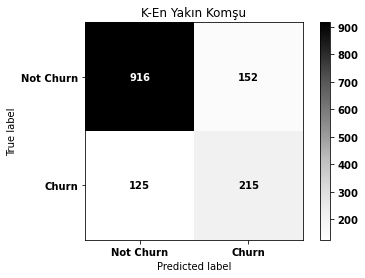

In [13]:
conf_matrix = confusion_matrix(y_test, knn_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("K-En Yakın Komşu")

In [14]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.svm import SVC

svm = SVC(C=0.2,kernel="rbf",probability=True)
kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(svm, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(svm, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(svm, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)


kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

svm = svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
print(classification_report(y_test,svm_pred))    

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1068
           1       0.70      0.56      0.63       340

    accuracy                           0.84      1408
   macro avg       0.79      0.74      0.76      1408
weighted avg       0.83      0.84      0.83      1408



In [15]:
accuracy_series = accuracy_series.append(pd.Series(data=accuracy_scores),ignore_index=True)
recall_series = recall_series.append(pd.Series(data=recall_scores),ignore_index=True)
f1_series = f1_series.append(pd.Series(data=f1_scores),ignore_index=True)

Text(0.5, 1.0, 'Destek Vektör Makineleri')

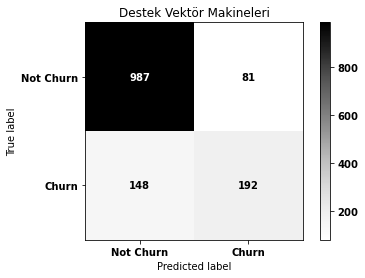

In [16]:
conf_matrix = confusion_matrix(y_test, svm_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("Destek Vektör Makineleri")

In [17]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier
dcs = DecisionTreeClassifier(random_state=12,criterion="entropy",max_depth=9)

kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(dcs, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(dcs, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(dcs, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)

kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

dcs = dcs.fit(X_train,y_train)
dcs_pred = dcs.predict(X_test)
print(classification_report(y_test,dcs_pred)) 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1068
           1       0.67      0.62      0.64       340

    accuracy                           0.83      1408
   macro avg       0.78      0.76      0.77      1408
weighted avg       0.83      0.83      0.83      1408



In [18]:
accuracy_series = accuracy_series.append(pd.Series(data=accuracy_scores),ignore_index=True)
recall_series = recall_series.append(pd.Series(data=recall_scores),ignore_index=True)
f1_series = f1_series.append(pd.Series(data=f1_scores),ignore_index=True)

Text(0.5, 1.0, 'Karar Ağaçları')

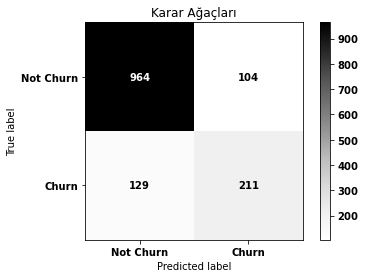

In [19]:
conf_matrix = confusion_matrix(y_test, dcs_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("Karar Ağaçları")

In [20]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=15,criterion="entropy",max_depth=9)

kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(rfc, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(rfc, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(rfc, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)

kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

rfc = rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))   

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1068
           1       0.71      0.59      0.65       340

    accuracy                           0.84      1408
   macro avg       0.79      0.76      0.77      1408
weighted avg       0.84      0.84      0.84      1408



In [21]:
accuracy_series = accuracy_series.append(pd.Series(data=accuracy_scores),ignore_index=True)
recall_series = recall_series.append(pd.Series(data=recall_scores),ignore_index=True)
f1_series = f1_series.append(pd.Series(data=f1_scores),ignore_index=True)

Text(0.5, 1.0, 'Rastgele Orman')

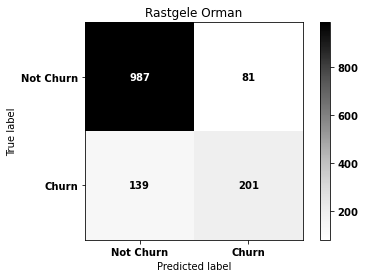

In [22]:
conf_matrix = confusion_matrix(y_test, rfc_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("Rastgele Orman")

In [23]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

kf = KFold(n_splits=5,random_state=42,shuffle=True)
accuracy_scores = cross_val_score(bnb, X_sc, y, scoring='accuracy', cv=kf, n_jobs=-1)
recall_scores = cross_val_score(bnb, X_sc, y, scoring='recall', cv=kf, n_jobs=-1)
f1_scores = cross_val_score(bnb, X_sc, y, scoring='f1', cv=kf, n_jobs=-1)

kf.get_n_splits(X_sc)
for train_index, test_index in kf.split(X_sc):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y[train_index], y[test_index]

bnb = bnb.fit(X_train,y_train)
bnb_pred = bnb.predict(X_test)
print(classification_report(y_test,bnb_pred))   

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1068
           1       0.61      0.71      0.66       340

    accuracy                           0.82      1408
   macro avg       0.76      0.78      0.77      1408
weighted avg       0.83      0.82      0.83      1408



In [24]:
accuracy_series = accuracy_series.append(pd.Series(data=accuracy_scores),ignore_index=True)
recall_series = recall_series.append(pd.Series(data=recall_scores),ignore_index=True)
f1_series = f1_series.append(pd.Series(data=f1_scores),ignore_index=True)

Text(0.5, 1.0, 'Bernoulli Naive Bayes')

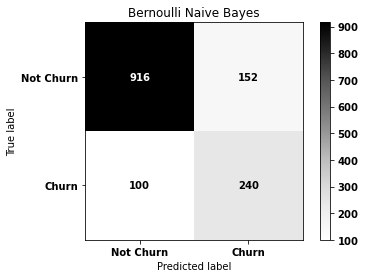

In [25]:
conf_matrix = confusion_matrix(y_test, bnb_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Churn","Churn"])
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({"font.weight":"bold"})
disp.plot(cmap='Greys',values_format="")
disp.ax_.set_title("Bernoulli Naive Bayes")

In [26]:
s1 = pd.Series(5*["Logistic Regression"])
s2 = pd.Series(5*["K-NN"])
s3 = pd.Series(5*["SVM"])
s4 = pd.Series(5*["Decision Tree"])
s5 = pd.Series(5*["Random Forest"])
s6 = pd.Series(5*["Naive Bayes"])
model_name = s1.append(s2,ignore_index=True)
model_name = model_name.append(s3,ignore_index=True)
model_name = model_name.append(s4,ignore_index=True)
model_name = model_name.append(s5,ignore_index=True)
model_name = model_name.append(s6,ignore_index=True)


In [27]:
comp_accuracy = pd.concat([model_name,accuracy_series],axis=1)
comp_accuracy = comp_accuracy.rename(columns={0:"Model Name",1:"Accuracy Scores"})

comp_recall = pd.concat([model_name,recall_series],axis=1)
comp_recall = comp_recall.rename(columns={0:"Model Name",1:"Recall Scores"})

comp_f1 = pd.concat([model_name,f1_series],axis=1)
comp_f1 = comp_f1.rename(columns={0:"Model Name",1:"F1 Scores"})


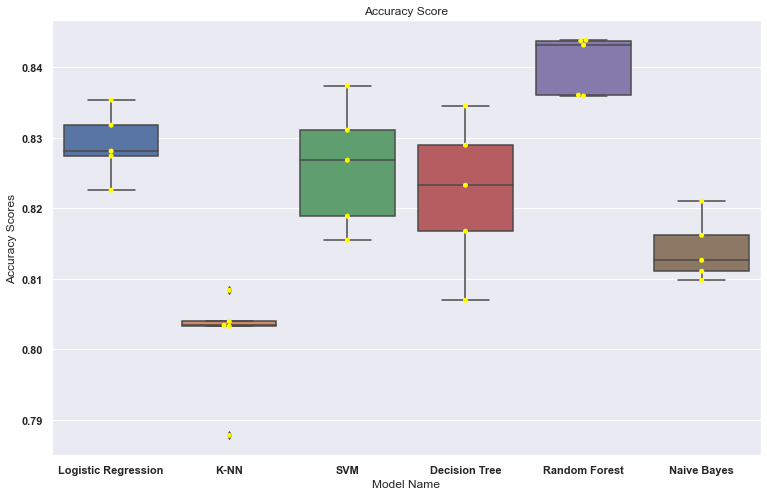

In [28]:
sns.set(rc={'figure.figsize':(12.7,8)})
ax = sns.boxplot(x="Model Name", y="Accuracy Scores", data=comp_accuracy).set_title("Accuracy Score")
ax = sns.swarmplot(x="Model Name", y="Accuracy Scores", data=comp_accuracy, color="Yellow")

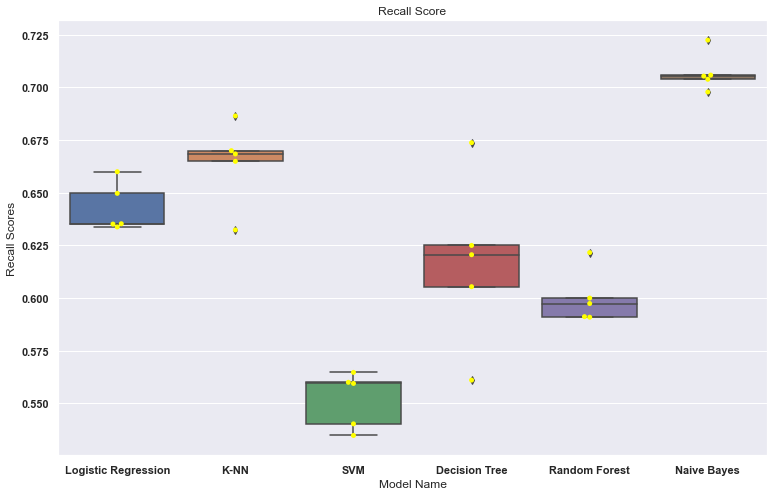

In [29]:
sns.set(rc={'figure.figsize':(12.7,8)})
ax = sns.boxplot(x="Model Name", y="Recall Scores", data=comp_recall).set_title("Recall Score")
ax = sns.swarmplot(x="Model Name", y="Recall Scores", data=comp_recall, color="Yellow")

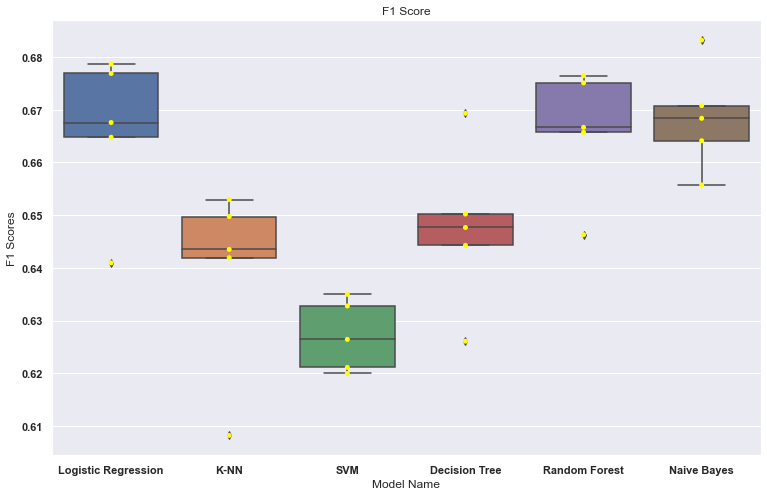

In [30]:
sns.set(rc={'figure.figsize':(12.7,8)})
ax = sns.boxplot(x="Model Name", y="F1 Scores", data=comp_f1).set_title("F1 Score")
ax = sns.swarmplot(x="Model Name", y="F1 Scores", data=comp_f1, color="Yellow")

No Skill: ROC AUC=0.50000
Logistic Regression: ROC AUC=0.87681
K-Nearest Neighbours: ROC AUC=0.84958
Support Vector Machine: ROC AUC=0.86945
Decision Tree: ROC AUC=0.85802
Random Forest: ROC AUC=0.89311
Bernoulli Naive Bayes: ROC AUC=0.87282


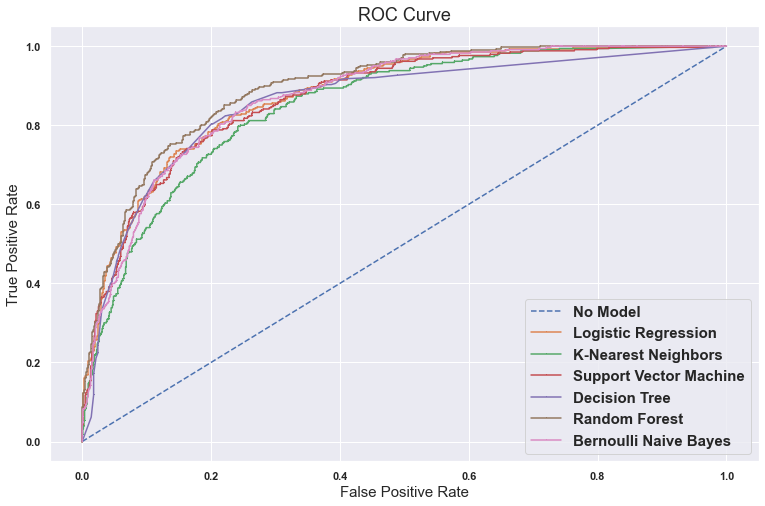

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

log_auc = roc_auc_score(y_test, logr.predict_proba(X_test)[:, 1])
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
svm_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
rfc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
dcs_auc = roc_auc_score(y_test, dcs.predict_proba(X_test)[:, 1])
bnb_auc = roc_auc_score(y_test, bnb.predict_proba(X_test)[:, 1])


print('No Skill: ROC AUC=%.5f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.5f' % (log_auc))
print('K-Nearest Neighbours: ROC AUC=%.5f' % (knn_auc))
print('Support Vector Machine: ROC AUC=%.5f' % (svm_auc))
print('Decision Tree: ROC AUC=%.5f' % (dcs_auc))
print('Random Forest: ROC AUC=%.5f' % (rfc_auc))
print('Bernoulli Naive Bayes: ROC AUC=%.5f' % (bnb_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, logr.predict_proba(X_test)[:, 1])
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm.predict_proba(X_test)[:, 1])
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
dcs_fpr, dcs_tpr, _ = roc_curve(y_test, dcs.predict_proba(X_test)[:, 1])
bnb_fpr, bnb_tpr, _ = roc_curve(y_test, bnb.predict_proba(X_test)[:, 1])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Model')

plt.plot(log_fpr, log_tpr, marker=',', label='Logistic Regression')
plt.plot(knn_fpr, knn_tpr, marker=',', label='K-Nearest Neighbors')
plt.plot(svm_fpr, svm_tpr, marker=',', label='Support Vector Machine')
plt.plot(dcs_fpr, dcs_tpr, marker=',', label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, marker=',', label='Random Forest')
plt.plot(bnb_fpr, bnb_tpr, marker=',', label='Bernoulli Naive Bayes')

plt.title("ROC Curve",fontsize=18)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# show the legend
plt.legend(fontsize=15)
# show the plot
plt.show()